# Weather forecasting

The goal of this project is to predict the temperature of the next month based on the previous 24 months. The data is from the [NASA GISS Surface Temperature Analysis plateform](https://data.giss.nasa.gov/gistemp/). 

This specific dataset is for the Carpiquet commune in France [Carpiquet weather data](https://data.giss.nasa.gov/cgi-bin/gistemp/stdata_show_v4.cgi?id=FRM00007027&ds=14&dt=1). 

We try different models and compare them to see which one is the best for this specific problem.
The models we try are:
- Naive predictions (predicting the temperature of the next month to be the same as the current month, or the average of the last two months)
- Neural network
- Convolutional neural network
- LSTM

In [904]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Data preprocessing

In [905]:
# Load dataset and drop unnecessary columns

data = pd.read_csv('station.csv')
data = data.loc[:, "JAN" : "DEC"]

In [906]:
# Create time series
time_series = []
for i , row in data.iterrows():
  time_series = time_series + list(row)


time_series = np.array(time_series)

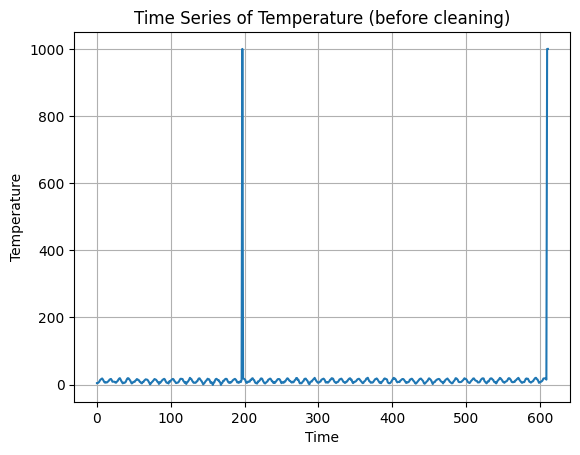

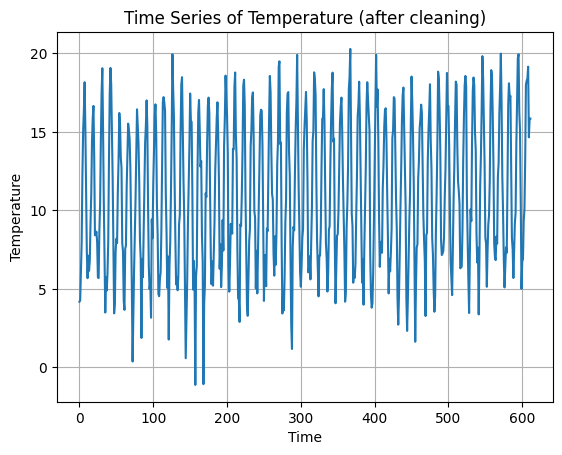

In [907]:
# Outlier detection and removal

plt.plot(time_series)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Time Series of Temperature (before cleaning)")
plt.grid()
plt.show()

# Replace outiliers with mean value
time_series[time_series > 100] = np.mean(time_series)


plt.plot(time_series)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Time Series of Temperature (after cleaning)")
plt.grid()
plt.show()



In [908]:
# Train test split
training_series = time_series[:int(len(time_series) * 0.8)]
testing_series = time_series[int(len(time_series) * 0.8):]



## Naive predictions

Mean Squared Error of shift forecast:  7.768316194698216
Mean Absolute Error of shift forecast:  2.2956711400407155


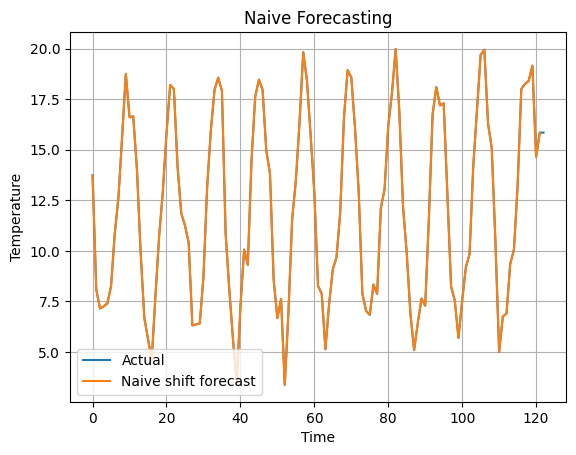

Mean Squared Error of mean forecast:  13.282953801714143
Mean Absolute Error of mean forecast:  3.106098856209151


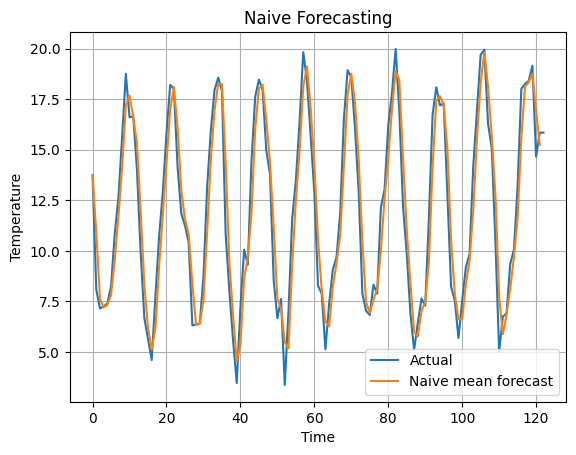

In [909]:
# Naive Forecasting (Baseline) : the previous value
shift_forecast = []
for i in range(1, len(testing_series)):
    shift_forecast.append(testing_series[i-1])

print("Mean Squared Error of shift forecast: ", mean_squared_error(testing_series[1:], shift_forecast))
print("Mean Absolute Error of shift forecast: ", mean_absolute_error(testing_series[1:], shift_forecast))
plt.plot(testing_series, label="Actual")
plt.plot(shift_forecast, label="Naive shift forecast")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Naive Forecasting")
plt.legend()
plt.grid()
plt.show()


# Naive Forecasting (Baseline) : mean of the two previous values

mean_forecast = []
mean_forecast.append(testing_series[0])
for i in range(2, len(testing_series)):
    mean_forecast.append(testing_series[i-2:i].mean())

print("Mean Squared Error of mean forecast: ", mean_squared_error(testing_series[1:], mean_forecast))
print("Mean Absolute Error of mean forecast: ", mean_absolute_error(testing_series[1:], mean_forecast))
plt.plot(testing_series, label="Actual")
plt.plot(mean_forecast, label="Naive mean forecast")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Naive Forecasting")
plt.legend()
plt.grid()
plt.show()




## Windowed dataset

In [910]:
# Windowing
window_size = 24
def windowed_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

training_dataset = windowed_dataset(training_series, window_size=window_size, batch_size=16)

testing_dataset = windowed_dataset(testing_series, window_size=window_size, batch_size=16)


for feature, label in testing_dataset.take(1):
  print(feature.shape)
  print(label.shape)
  break


(16, 24, 1)
(16, 1)


## Dense neural network

In [911]:


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=[window_size], activation='sigmoid'),
    tf.keras.layers.Dense(16,  activation='sigmoid'),
    tf.keras.layers.Dense(1)
])


In [912]:

model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 32)                800       
                                                                 
 dense_195 (Dense)           (None, 16)                528       
                                                                 
 dense_196 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1345 (5.25 KB)
Trainable params: 1345 (5.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


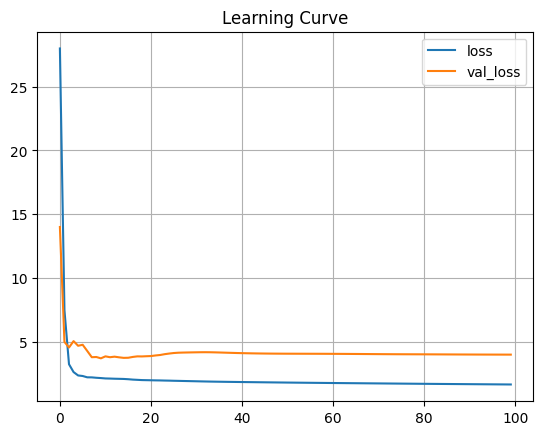

In [913]:

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6))

model.fit(training_dataset, epochs=100, validation_data=testing_dataset, verbose=0)
#print learning curve
pd.DataFrame(model.history.history).plot()
plt.title("Learning Curve")
plt.grid()
plt.show()


7/7 [==============================] - 0s 2ms/step
Mean Squared Error of model:  3.9945692352695747
Mean Absolute Error of model:  1.4404336170889867


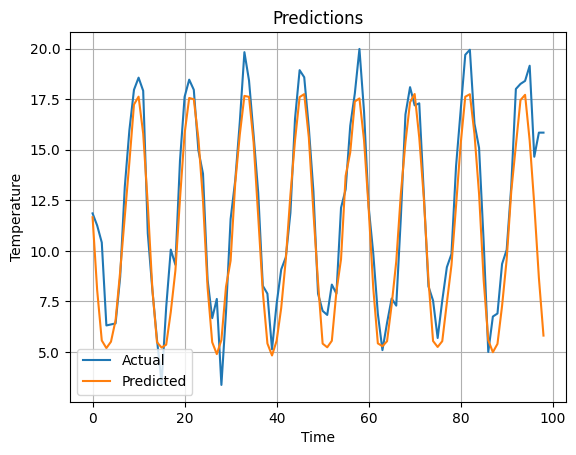

In [914]:



predictions = model.predict(testing_dataset)
print("Mean Squared Error of model: ", mean_squared_error(testing_series[window_size:], predictions))
print("Mean Absolute Error of model: ", mean_absolute_error(testing_series[window_size:], predictions))

plt.plot(testing_series[window_size:], label="Actual")
plt.plot(predictions, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Predictions")
plt.grid()
plt.legend()
plt.show()



## Convolutional neural network

In [915]:
# CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, input_shape=[None, 1], activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,  activation='tanh'),
    tf.keras.layers.Dense(8,  activation='tanh'),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, None, 128)         512       
                                                                 
 dropout_31 (Dropout)        (None, None, 128)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 64)          24640     
                                                                 
 dropout_32 (Dropout)        (None, None, 64)          0         
                                                                 
 dense_197 (Dense)           (None, None, 16)          1040      
                                                                 
 dense_198 (Dense)           (None, None, 8)           136       
                                                                 
 dense_199 (Dense)           (None, None, 1)         

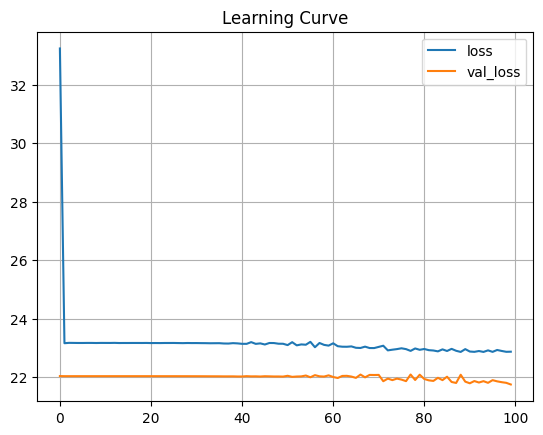

In [916]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6))

model.fit(training_dataset, epochs=100, validation_data=testing_dataset, verbose=0)

pd.DataFrame(model.history.history).plot()
plt.title("Learning Curve")
plt.grid()
plt.show()


7/7 [==============================] - 0s 2ms/step
Mean Squared Error of model:  22.36940446450116
Mean Absolute Error of model:  4.222783932992158


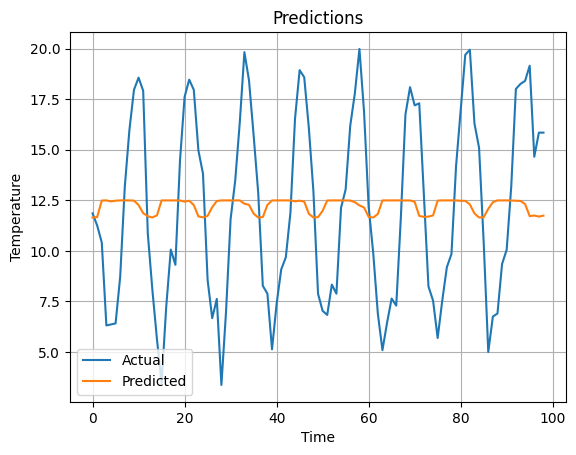

In [930]:
predictions = model.predict(testing_dataset)

predictions = predictions[:, -1, 0]

# for feature, label in testing_dataset.take(1):
#   print(feature.shape)
#   print(label.shape)

#   print(model.predict(feature).shape)
#   break

print("Mean Squared Error of model: ", mean_squared_error(testing_series[window_size:], predictions))
print("Mean Absolute Error of model: ", mean_absolute_error(testing_series[window_size:], predictions))

plt.plot(testing_series[window_size:], label="Actual")
plt.plot(predictions, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Predictions")
plt.grid()
plt.legend()
plt.show()


## LSTM

In [931]:
# RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_7 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_8 (LSTM)               (None, 16)                3136      
                                                                 
 dense_200 (Dense)           (None, 1)                 17        
                                                                 
Total params: 32465 (126.82 KB)
Trainable params: 32465 (126.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


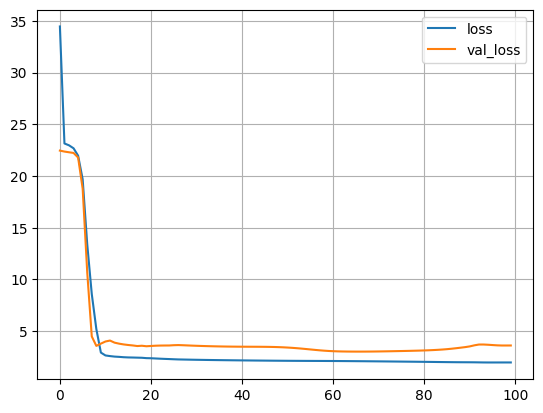

In [932]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6))
model.fit(training_dataset, epochs=100, validation_data=testing_dataset, verbose=0)

pd.DataFrame(model.history.history).plot()
plt.grid()
plt.show()

7/7 [==============================] - 0s 4ms/step
Mean Squared Error of model:  3.6213535956212146
Mean Absolute Error of model:  1.451080535607361


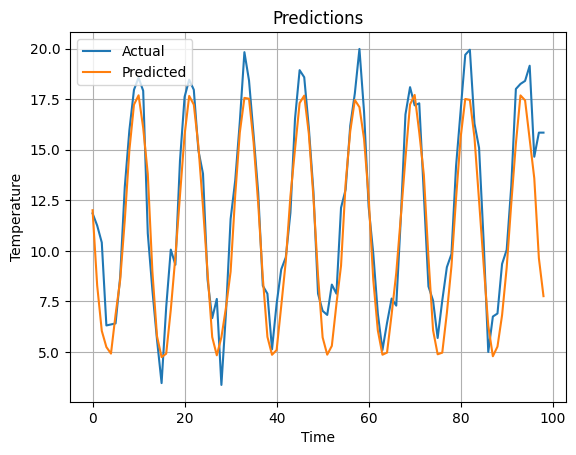

In [933]:
predictions = model.predict(testing_dataset)
print("Mean Squared Error of model: ", mean_squared_error(testing_series[window_size:], predictions))
print("Mean Absolute Error of model: ", mean_absolute_error(testing_series[window_size:], predictions))

plt.plot(testing_series[window_size:], label="Actual")
plt.plot(predictions, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Predictions")
plt.grid()
plt.legend()
plt.show()
